In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from astropy.coordinates import CartesianRepresentation, CartesianDifferential, ICRS, SkyCoord
import astropy.units as u
from astropy.io import ascii
from PyAstronomy import pyasl # for two body problem

pc_in_m = 3.086e16
Msun = 2e30 # kg
G = 6.67e-11 # mks


In [2]:
# define utility functions for generating the mock binary sample

def get_random_sample_of_y_with_same_distance_distrution_as_x(dist_x, dist_y, nbins,
    dmax = 200):
    '''
    dist_x and dist_y are arrays of distaces (or any other quantity). 
    This is return a mmask for y that yields a similar distance distribution 
    to the distance distribution of x. 
    '''
    bins = np.linspace(0, dmax, nbins)
    bin_cens = bins[:-1] + 0.5*np.diff(bins)
    hist_x, _ = np.histogram(dist_x, bins = bins)
    hist_y, _ = np.histogram(dist_y, bins = bins)
    ratio = hist_x/hist_y
    ratio[~np.isfinite(ratio)] = 0
    ratio /= np.max(ratio)
    
    prob_keep = np.interp(dist_y, bin_cens, ratio)
    rands = np.random.uniform(0, 1, len(dist_y))
    msk = rands < prob_keep
    return msk

def transform_from_coordinate_system_around_a_point_p(p, X, V):
    '''
    p is the coordinates of a point, in the helocentric frame
    X and V are arrays of positions and velocities, in a frame centered
        on p with z axis pointing toward the origin. 
    This transforms x and V to a heliocentric frame. 
    '''
    z_ax = np.array(p)/np.linalg.norm(p)
    x_ax, y_ax = generate_vectors_perpendicular_to_z_axis(z_ax = z_ax)
    
    x0, y0, z0 = rotate_to_vectors(X = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), 
                                   v1 = x_ax, v2 = y_ax, v3 = z_ax)
    # now x0 y0 z0 define the heliocentric frame, in the frame of point p. 
    # We'll now transform to that frame
    
    X_new = rotate_to_vectors(X = X, v1 = x0, v2 = y0, v3 = z0)
    V_new = rotate_to_vectors(X = V, v1 = x0, v2 = y0, v3 = z0)
    return X_new, V_new

def transform_velocities_to_orthogonal_frame(p, V):
    '''
    This essentially reverses transform_from_coordinate_system_around_a_point_p():
        it takes an array of velocities in a heliocentric cartesian frame and transforms
        them to a different cartesian frame centered on point p with z axis pointing 
        toward the Sun.
    '''
    z_ax = np.array(p)/np.linalg.norm(p)
    x_ax, y_ax = generate_vectors_perpendicular_to_z_axis(z_ax = z_ax)
    V_new = rotate_to_vectors(X = V, v1 = x_ax, v2 = y_ax, v3 = z_ax)
    return V_new
    
def generate_vectors_perpendicular_to_z_axis(z_ax):
    '''
    generate two random unit vectors in the plane perpendicular to a vector.
    z_ax is any unit vector. 
    '''
    dummy_vec = [1, 2, 3]
    dummy_vec = np.array(dummy_vec)/np.linalg.norm(dummy_vec)
    x_ax = np.cross(z_ax, dummy_vec) # Now x_ax _|_ z_ax
    x_ax = x_ax/np.linalg.norm(x_ax) # now x_ax and z_ax have norm 1
    y_ax = np.cross(z_ax, x_ax) # Now (y_ax _|_ z_ax) AND (y_ax _|_ x_ax)
    return x_ax, y_ax

def rotate_to_vectors(X, v1, v2, v3):
    ''' 
    Rotates the coordinate axes such that v1 is mapped to the x axis,
    v2 is mapped to the y axis, and v3 is mapped to the z axis. 
    
    Returns an array of positions in the same format as X.
    
    parameters
    ------------
    X: array of positions such that X[0] = [x0, y0, z0] and X[1] = [x1, y1, z1], etc.
    v1: array of floats of length 3, which will be mapped to (1, 0, 0) in the 
        rotation.
    v2: same. Will be mapped to (0, 1, 0).
    v3: same. Will be mapped to (0, 0, 1)
    
    returns
    ------------
    new_xyz: array of positions in new rotates basis such that 
             X[0] = [x0, y0, z0] and X[1] = [x1, y1, z1], etc.
    '''
    if (np.abs(np.dot(v1, v2)) > 1e-6) | (np.abs(np.dot(v1, v3)) > 1e-6) | (np.abs(np.dot(v2, v3)) > 1e-6):
        print("Oh oh. The basis you gave me isn't orthogonal. All bets are off.")
    
    N = [v1, v2, v3]
    new_xyz = np.dot(N, X.T)
    return new_xyz.T

def prepare_ranges_for_plotting_errorbars(ranges):
    '''
    ranges is a list of length three lists, each giving three percentiles of some
    parameter (typically [15.9, 50, 84.1] for median and 1-sigma). This returns
    a length N list of median values and 'yerr' ranges which can be fed into plt.errorbar.
    '''
    ranges = np.array(ranges)
    lower, med, upper = ranges.T
    lower_error, upper_error = med - lower, upper - med
    lower_error, upper_error = np.abs(lower_error), np.abs(upper_error)
    yerrs = [lower_error, upper_error]
    return med, yerrs

def simulate_Keplerian_orbit(P, m1, q, ecc, Omega, inc, w1):
    '''
    P in days
    m1 in solar masses 
    q = m2/m1 is between 0 and 1 
    ecc is between 0 and 1
    Omega, the longitude of the ascending node, is between 0 and 360 (uniform distribution)
    inc is between 0 and 90 (sin(i) distribution)
    w1, the argument of periapsis of star 1, is between 0 and 360 (uniform distribution )
    
    returns coordinates oriented such that the z axis points toward the observer 
         positions and velocities in mks units
    '''
    from PyAstronomy import pyasl
    m1_kg = m1 * Msun
    m2_kg = m1_kg * q
    P_sec = 86400 * P
    
    # true semi-major axis, in meters
    a_m = (P_sec**2 * G * (m1_kg + m2_kg)/(4 * np.pi**2))**(1/3)
    
    a2_m = a_m/(1 + q)
    a1_m = a_m - a2_m
    
    ellipse1 = pyasl.KeplerEllipse(a = a1_m, per = P_sec, e = ecc, Omega = Omega, i = inc, w = w1)
    ellipse2 = pyasl.KeplerEllipse(a = a2_m, per = P_sec, e = ecc, Omega = Omega, i = inc, w = w1 + 180)
    
    t = np.random.uniform(0, P_sec, 1)
    
    pos1 = ellipse1.xyzPos(t)
    pos2 = ellipse2.xyzPos(t)
    
    vel1 = ellipse1.xyzVel(t)
    vel2 = ellipse2.xyzVel(t)
    
    return pos1, pos2, vel1, vel2, a_m
    

    

In [3]:
# read in the observed binaries 

cat = ascii.read('hernandez_gaia_xmatch.csv', format='csv')
c1 = SkyCoord(cat['ra_1'].data.data, cat['dec_1'].data.data, unit = (u.deg, u.deg)) 
c2 = SkyCoord(cat['ra_2'].data.data, cat['dec_2'].data.data, unit = (u.deg, u.deg)) 

theta_deg_obs = c1.separation(c2).deg # angular separation
d_pc_obs = 1000/cat['parallax_1'].data.data
s_pc_obs = d_pc_obs*theta_deg_obs*np.pi/180 # physical separation 
mu_tot_obs = np.sqrt(cat['pmra_1'].data.data**2 + cat['pmdec_1'].data.data**2) # total proper motion
# note that the gaia 'pmra' is realy pmra * cos(dec)

delta_mu_ra_obs = np.abs(cat['pmra_1'].data.data - cat['pmra_2'].data.data)
delta_mu_dec_obs = np.abs(cat['pmdec_1'].data.data - cat['pmdec_2'].data.data)

delta_v_ra_obs = 4.74*delta_mu_ra_obs/cat['parallax_1'].data.data
delta_v_dec_obs = 4.74*delta_mu_dec_obs/cat['parallax_1'].data.data

# combine ra and dec proper motions 
obs_s_pc = np.concatenate([s_pc_obs, s_pc_obs]) 
obs_delta_v = np.concatenate([delta_v_ra_obs, delta_v_dec_obs])

# get system radial velocties where available
obs_rv = cat['radial_velocity_1'].data.data
obs_rv[obs_rv == 0] = cat['radial_velocity_2'].data.data[obs_rv ==0]
obs_rv= obs_rv[obs_rv != 0]


In [4]:
# generate center-of-mass positions 

lim = 130 # first, assume stars are uniformly distributed in space within 130 pc
N = 200000 # some large number 
x = np.random.uniform(-lim, lim, N)
y = np.random.uniform(-lim, lim, N)
z = np.random.uniform(-lim, lim, N)
r = (x*x + y*y + z*z)**(1/2)
msk = r < lim 
x, y, z, r = x[msk], y[msk], z[msk], r[msk] # throw out stars beyond 130 pc. Now we 

msk = get_random_sample_of_y_with_same_distance_distrution_as_x(
        dist_x = d_pc_obs, dist_y = r, nbins = 8, dmax = 120)
x, y, z, r = x[msk], y[msk], z[msk], r[msk] # now we have a reasonable distance distribution
N = len(r)

# generate center-of-mass velocities
sigma_v = 25
vx = sigma_v*np.random.randn(N)
vy = sigma_v*np.random.randn(N)
vz = sigma_v*np.random.randn(N)



In [5]:
# generate orbits for each binary and transform to a heliocentric 
# cartesian frame. 

all_eccs = np.random.uniform(0, 1, N)
all_qs = np.random.uniform(0.8, 1, N) 
all_ms = np.random.uniform(0.5, 0.6, N) 
all_logPs = np.random.uniform(7, 12, N) # days
all_Ps = 10**all_logPs

all_incs = np.arccos(1-np.random.uniform(size = N)) * 180/np.pi # sin(i) distribution in degrees
all_w = np.random.uniform(0, 360, N)
all_Omega = np.random.uniform(0, 360, N)

all_a = []
x1s, y1s, z1s = [], [], []
x2s, y2s, z2s = [], [], []
vx1s, vy1s, vz1s = [], [], []
vx2s, vy2s, vz2s = [], [], []

for i, P in enumerate(all_Ps):
    pos1, pos2, vel1, vel2, a_m = simulate_Keplerian_orbit(
        P = P, m1 = all_ms[i], q = all_qs[i], ecc = all_eccs[i], 
        Omega = all_Omega[i], inc = all_incs[i], w1 = all_w[i])
    all_a.append(a_m/pc_in_m) # true semi-major axis in pc
    X1, V1 = transform_from_coordinate_system_around_a_point_p(p = [x[i], y[i], z[i]], 
        X = pos1, V = vel1)
    X2, V2 = transform_from_coordinate_system_around_a_point_p(p = [x[i], y[i], z[i]], 
        X = pos2, V = vel2)
    
    # heliocentric coordinates for each component
    x1, y1, z1 = x[i] + X1[0][0]/pc_in_m, y[i] + X1[0][1]/pc_in_m, z[i] + X1[0][2]/pc_in_m
    x2, y2, z2 = x[i] + X2[0][0]/pc_in_m, y[i] + X2[0][1]/pc_in_m, z[i] + X2[0][2]/pc_in_m

    # transform from m/s to km/s
    vx1, vy1, vz1 = vx[i] + V1[0][0]/1000, vy[i] + V1[0][1]/1000, vz[i] + V1[0][2]/1000
    vx2, vy2, vz2 = vx[i] + V2[0][0]/1000, vy[i] + V2[0][1]/1000, vz[i] + V2[0][2]/1000
    
    x1s.append(x1)
    y1s.append(y1)
    z1s.append(z1)
    vx1s.append(vx1)
    vy1s.append(vy1)
    vz1s.append(vz1)
    
    x2s.append(x2)
    y2s.append(y2)
    z2s.append(z2)
    vx2s.append(vx2)
    vy2s.append(vy2)
    vz2s.append(vz2)

x1s, y1s, z1s = np.array(x1s), np.array(y1s), np.array(z1s)
x2s, y2s, z2s = np.array(x2s), np.array(y2s), np.array(z2s) 
vx1s, vy1s, vz1s = np.array(vx1s), np.array(vy1s), np.array(vz1s)
vx2s, vy2s, vz2s = np.array(vx2s), np.array(vy2s), np.array(vz2s)
all_a = np.array(all_a)

# now x1s, vx1s, etc., are the positions and velocities of the two components
# of each binary, in a cartesian frame centered on the sun. 


In [6]:
# now transform the heliocentric cartesian coordinates into spherical

coord1 = ICRS(x = x1s*u.pc, y = y1s*u.pc, z = z1s*u.pc,
    v_x=vx1s*u.km/u.s, v_y=vy1s*u.km/u.s, v_z=vz1s*u.km/u.s,
    representation_type=CartesianRepresentation,
    differential_type=CartesianDifferential)  

coord2 = ICRS(x = x2s*u.pc, y = y2s*u.pc, z =z2s*u.pc,
    v_x=vx2s*u.km/u.s, v_y=vy2s*u.km/u.s, v_z=vz2s*u.km/u.s,
    representation_type=CartesianRepresentation,
    differential_type=CartesianDifferential)  

pmra1, pmdec1 = coord1.proper_motion
pmra2, pmdec2 = coord2.proper_motion
ra1, dec1, dist1 = coord1.spherical.lon.deg, coord1.spherical.lat.deg, coord1.spherical.distance.pc
ra2, dec2, dist2 = coord2.spherical.lon.deg, coord2.spherical.lat.deg, coord2.spherical.distance.pc

vr1 = coord1.radial_velocity.value
vr2 = coord2.radial_velocity.value


mu_tot1 = np.sqrt(pmra1.value**2 + pmdec1.value**2) # total proper motion 
delta_mu_ra = np.abs(pmra1.value - pmra2.value) # 1d proper motion difference 
delta_mu_dec = np.abs(pmdec1.value - pmdec2.value)

parallax = 1000/r # in mas 
delta_v_ra = 4.74*delta_mu_ra/parallax
delta_v_dec = 4.74*delta_mu_dec/parallax
delta_v_1d = np.concatenate([delta_v_ra, delta_v_dec]) # combine ra and dec components

# angular separation in radians
theta = coord1.separation(coord2).deg * np.pi/180 

proj_sep = theta*r
proj_sep_both_comp = np.concatenate([proj_sep, proj_sep])
proj_sep_three_comp = np.concatenate([proj_sep, proj_sep, proj_sep])

# true velocity differences
true_delta_vx = np.abs(vx1s - vx2s) 
true_delta_vy = np.abs(vy1s - vy2s) 
true_delta_vz = np.abs(vz1s - vz2s) 
true_delta_v_1d = np.concatenate([true_delta_vx, true_delta_vy, true_delta_vz])

# remove pairs unlikely to be classfied as binaries
vmax_kms = 4
m = (delta_v_ra < vmax_kms) & (delta_v_dec < vmax_kms) & (np.abs(vr1 - vr2) < vmax_kms)
msk = np.concatenate([m, m])

# get binned medians 
bin_edges = np.logspace(-2.6, 1, 15)
log_bin_edges = np.log10(bin_edges)
log_bin_cens = log_bin_edges[:-1] + 0.5*np.diff(log_bin_edges)
delta_vs, delta_vs_true, delta_vs_cut = [], [], []
for i, bc in enumerate(log_bin_cens):
    these = (proj_sep_both_comp > bin_edges[i]) & (proj_sep_both_comp < bin_edges[i+1]) 
    these_cut = these & msk
    these_true = (proj_sep_three_comp > bin_edges[i]) & (proj_sep_three_comp < bin_edges[i+1])
    delta_vs.append(np.median(delta_v_1d[these]))
    delta_vs_true.append(np.median(true_delta_v_1d[these_true]))
    delta_vs_cut.append(np.median(delta_v_1d[these_cut]))

# get medians and 1 sigma for the observed binaries. First just reconstruct the bins
obs_edges = [0.0032, 0.016, 0.08, 0.4, 2, 10]
log_obs_edges = np.log10(obs_edges)
log_obs_centers = log_obs_edges[:-1] + 0.5*np.diff(log_obs_edges)

obs_x = []
for i, cen in enumerate(log_obs_centers):
    a = [obs_edges[i], 10**cen, obs_edges[i+1]]
    obs_x.append(a)
med_x, err_x = prepare_ranges_for_plotting_errorbars(ranges = obs_x)
    
delta_v_percentiles_obs = []
for i, bc in enumerate(log_obs_centers):
    these = (obs_s_pc > obs_edges[i]) & (obs_s_pc < obs_edges[i+1]) 
    delta_v_percentiles_obs.append(np.percentile(obs_delta_v[these],  [15.9, 50, 84.1]))
obs_med, obs_err = prepare_ranges_for_plotting_errorbars(ranges = delta_v_percentiles_obs)



Text(0,0.5,'$\\rm probability\\,\\,density$')

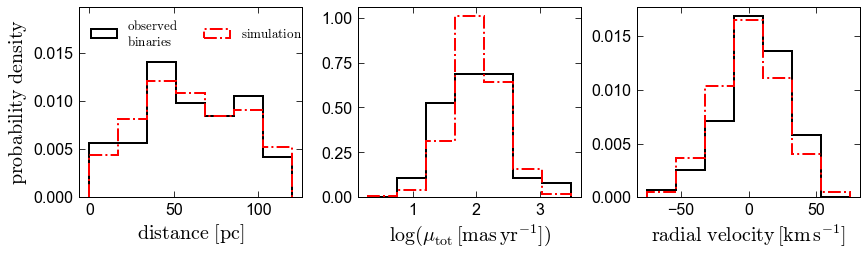

In [7]:
# plot the population demographics
dist_bins= np.linspace(0, 120, 8)
rv_bins = np.linspace(-75, 75, 8)
log_mu_bins = np.linspace(0.3, 3.5, 8)
f, ax = plt.subplots(1, 3, figsize = (14, 3.5))
plt.subplots_adjust(wspace = 0.25)

ax[0].set_xlabel(r'$\rm distance\,\,[pc]$', fontsize = 20)
ax[1].set_xlabel(r'$\log(\mu_{{\rm tot}}\,[{\rm mas\,yr^{-1}}])$', fontsize = 20)
ax[2].set_xlabel(r'${\rm radial\,\,velocity}\,[{\rm km\,s^{-1}}]$', fontsize = 20)
ax[0].hist(d_pc_obs, bins = dist_bins, color = 'k', linestyle = '-', lw = 2,
    histtype = 'step', density = True, label = r'$\rm observed$'+'\n'+r'$\rm binaries$')
ax[0].hist(r, bins = dist_bins, color = 'r', linestyle = '-.', lw = 2,
    histtype = 'step', density = True, label = r'$\rm simulation$')

ax[1].hist(np.log10(mu_tot_obs), bins = log_mu_bins, color = 'k', linestyle = '-', lw = 2,
    histtype = 'step', density = True, label = r'$\rm observed$'+'\n'+r'$\rm binaries$')

ax[1].hist(np.log10(mu_tot1), bins = log_mu_bins, color = 'r', linestyle = '-.', lw = 2,
    histtype = 'step', density = True, label =  r'$\rm simulation$')
    
ax[2].hist(obs_rv, bins = rv_bins, color = 'k', linestyle = '-', lw = 2,
    histtype = 'step', density = True, label =  r'$\rm observed$'+'\n'+r'$\rm binaries$')
ax[2].hist(vr1, bins = rv_bins, color = 'r', linestyle = '-.', lw = 2,
    histtype = 'step', density = True, label = r'$\rm simulation$')
ax[0].legend(loc = 'upper left', frameon = False, fontsize=13, ncol = 2)
ax[0].set_ylim(0, 0.0198)
for i in range(3):
    ax[i].tick_params(labelsize = 16)
ax[0].set_ylabel(r'$\rm probability\,\,density$', fontsize = 20)


Text(0.5,0,'$\\rm projected\\,\\,separation\\,\\,[pc]$')

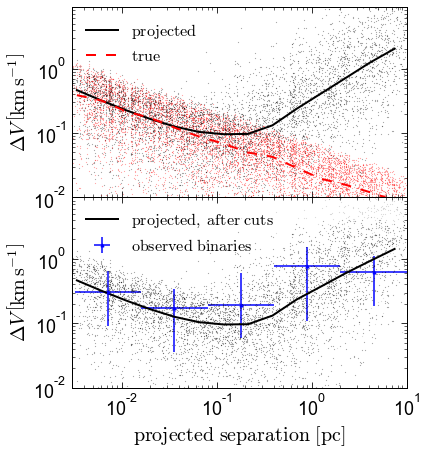

In [8]:
# plot the mock observations 
import plot_utils
f, ax = plot_utils.new_column(nrow = 2, xlim = [0.003, 10])

for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim(0.01, 9)
    ax[i].set_ylabel(r'$\Delta V\,{\rm \left[km\,s^{-1}\right]}$', fontsize =20)
ax[0].set_xticklabels([])
ax[0].plot(proj_sep_three_comp, true_delta_v_1d, 'r.', ms = 0.25, rasterized= True)
ax[0].plot(proj_sep_both_comp, delta_v_1d, 'k.', ms = 0.25, rasterized= True)
ax[0].plot(10**log_bin_cens, delta_vs, 'k', lw = 2, label = r'$\rm projected$')
ax[0].plot(10**log_bin_cens, delta_vs_true, 'r--', lw = 2, label = r'$\rm true$')
ax[0].legend(loc = 'upper left', frameon = False, fontsize = 16)

ax[1].plot(proj_sep_both_comp[msk], delta_v_1d[msk], 'k.', ms = 0.25, rasterized= True)
ax[1].plot(proj_sep_both_comp[~msk], delta_v_1d[~msk], 'k.', ms = 0.1, rasterized= True)
ax[1].plot(10**log_bin_cens, delta_vs_cut, 'k', lw = 2, 
    label = r'$\rm projected,\,\,after\,\,cuts$')
ax[1].errorbar(10**log_obs_centers, obs_med, xerr = err_x,
     yerr = obs_err, fmt = 'b^', ms = 3, label = r'$\rm observed\,\,binaries$')
ax[1].legend(loc = 'upper left', frameon = False, fontsize = 16)
ax[1].set_xlabel(r'$\rm projected\,\,separation\,\,[pc]$', fontsize = 20)
    


Text(0.5,0,'$\\rm projected\\,\\,separation\\,\\,[pc]$')

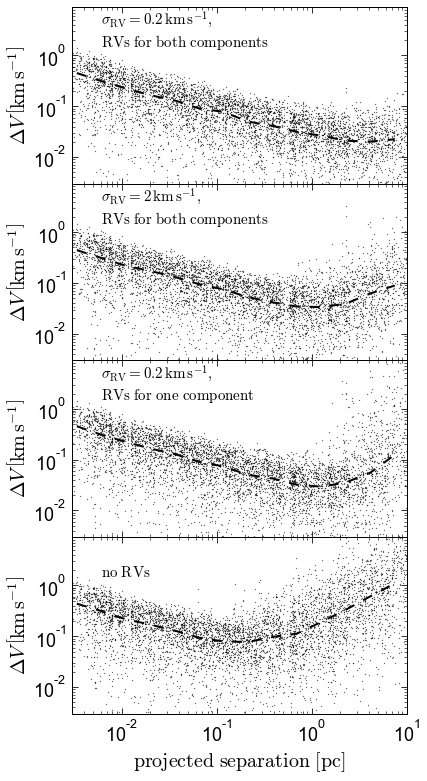

In [9]:
# finally, plot how well true DeltaVs can be recovered under different assumptions
mu_err = 0.05 # uncertainty in mas/yr 

all_dv, all_dv_mean = [], []
for i in range(4):
    if i == 0: # assume both rvs are known with 0.2 km/s uncertainty
        sigma_vr = 0.2
        rv1 = (vr1+sigma_vr*np.random.randn(len(vr1)))*u.km/u.s
        rv2 = (vr2+sigma_vr*np.random.randn(len(vr2)))*u.km/u.s
    elif i == 1: # assume both rvs are known with 2 km/s uncertainty
        sigma_vr = 2
        rv1 = (vr1+sigma_vr*np.random.randn(len(vr1)))*u.km/u.s
        rv2 = (vr2+sigma_vr*np.random.randn(len(vr2)))*u.km/u.s
    elif i == 2: # assume only one rvs is known, with 0.2 km/s uncertainty
        sigma_vr = 0.2
        rv1 = (vr1+sigma_vr*np.random.randn(len(vr1)))*u.km/u.s
        rv2 = rv1
    elif i == 3: # assume no rvs are known. 
        rv1 = 0*u.km/u.s
        rv2 = 0*u.km/u.s
      
    # assume distances are known perfectly.
    c1 = ICRS(ra = ra1*u.deg, dec = dec1*u.deg, distance = dist1*u.pc, 
        pm_ra_cosdec = (pmra1.value + mu_err*np.random.randn(len(pmra1.value)))*u.mas/u.yr, 
        pm_dec = (pmdec1.value + mu_err*np.random.randn(len(pmdec1.value)))*u.mas/u.yr, 
        radial_velocity = rv1) 
    
    c2 = ICRS(ra = ra2*u.deg, dec = dec2*u.deg, distance = dist2*u.pc, 
        pm_ra_cosdec = (pmra2.value + mu_err*np.random.randn(len(pmra1.value)))*u.mas/u.yr,
        pm_dec = (pmdec2.value + mu_err*np.random.randn(len(pmdec2.value)))*u.mas/u.yr, 
        radial_velocity = rv2)
    
    # transform to heliocentric cartesian
    vx1, vy1, vz1 = c1.velocity.d_x.to(u.km/u.s).value, c1.velocity.d_y.to(u.km/u.s).value, \
        c1.velocity.d_z.to(u.km/u.s).value
    vx2, vy2, vz2 = c2.velocity.d_x.to(u.km/u.s).value, c2.velocity.d_y.to(u.km/u.s).value, \
        c2.velocity.d_z.to(u.km/u.s).value


    # transform to a cartesian frame centered on one star with z axis pointing to the Sun. 
    V_rot1, V_rot2 = [], []
    for i in range(len(vx1)):
        V_new1 = transform_velocities_to_orthogonal_frame(p = [x1s[i], y1s[i], z1s[i]], 
            V = np.array([[vx1[i], vy1[i], vz1[i]]]))
        V_new2 = transform_velocities_to_orthogonal_frame(p = [x1s[i], y1s[i], z1s[i]], 
            V = np.array([[vx2[i], vy2[i], vz2[i]]]))
        V_rot1.append(V_new1[0])
        V_rot2.append(V_new2[0])
    V_rot1, V_rot2 = np.array(V_rot1), np.array(V_rot2)
    dv_1d = np.concatenate([np.abs(V_rot1[:, 0] - V_rot2[:, 0]), np.abs(V_rot1[:, 1] - V_rot2[:, 1])])
    all_dv.append(dv_1d)
    
    bin_edges = np.logspace(-2.6, 1, 15)
    log_bin_edges = np.log10(bin_edges)
    log_bin_cens = log_bin_edges[:-1] + 0.5*np.diff(log_bin_edges)
    delta_v_med = []
    for i, bc in enumerate(log_bin_cens):
        these = (proj_sep_both_comp > bin_edges[i]) & (proj_sep_both_comp < bin_edges[i+1]) 
        delta_v_med.append(np.median(dv_1d[these]))
    all_dv_mean.append(delta_v_med)
    
    
labels = [r'$\sigma_{{\rm RV}}=0.2\,{\rm km\,s^{-1}},$'+'\n'r'${\rm RVs\,\,for\,\,both\,\,components}}$',
    r'$\sigma_{{\rm RV}}=2\,{\rm km\,s^{-1}},$'+'\n'r'${\rm RVs\,\,for\,\,both\,\,components}}$',
    r'$\sigma_{{\rm RV}}=0.2\,{\rm km\,s^{-1}},$'+'\n'r'${\rm RVs\,\,for\,\,one\,\,component}}$',
    r'${\rm no\,\, RVs}}$']
f, ax = plot_utils.new_column(nrow = 4,  xlim = [0.003, 10])

for i in range(4):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim(0.003, 9)
    ax[i].set_ylabel(r'$\Delta V\,{\rm \left[km\,s^{-1}\right]}$', fontsize =20)
    ax[i].plot(proj_sep_both_comp, all_dv[i], 'k.', ms = 0.5, rasterized= False)
    ax[i].plot(10**log_bin_cens, all_dv_mean[i], 'k--', lw = 2)
    
    if i != 3:
        ax[i].set_xticklabels([])
    ax[i].text(0.006, 1.5, labels[i], fontsize=15)
ax[3].set_xlabel(r'$\rm projected\,\,separation\,\,[pc]$', fontsize = 20)

